In [54]:
import random
import math
import copy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA
from matplotlib.animation import FuncAnimation
from tqdm.notebook import trange, tqdm

from scipy.optimize import LinearConstraint
from scipy.optimize import milp

%matplotlib ipympl

# TOY POMDP problem - 2-State

|S| = 2

|A| = 2

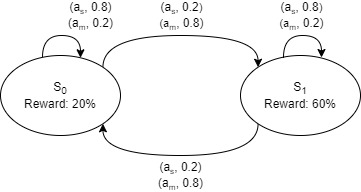

## Problem setup

Clumsy robot

In [4]:
STAY = 0
MOVE = 1
ACTIONS = [STAY, MOVE]
ACTION_INDEX = {a:a_i for a_i, a in enumerate(ACTIONS)}
ACTION_COUNT = len(ACTIONS)

STATES = [0,1]
STATE_COUNT = len(STATES)

In [5]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup tanle to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, len(ACTIONS), STATE_COUNT))
for s in STATES:
    for a_i, a in enumerate(ACTIONS):
        for s_p in STATES:
            transition_table[s,a_i,s_p] = transition_function(s,a,s_p)

# Randomized transition
def transition(s,a):
    a_i = ACTION_INDEX[a]
    s_p_probs = [transition_table[s, a_i, s_p] for s_p in STATES]
    return np.argmax(np.random.multinomial(n=1, pvals=s_p_probs))

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [6]:
OBS_RND = 0.7 # 70% of observation success
def observation_function(a, s_p, o):
    return OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)

observation_table = np.zeros((len(ACTIONS), STATE_COUNT, STATE_COUNT))
for a_i, a in enumerate(ACTIONS):
    for s_p in STATES:
        for o in STATES:
            observation_table[a_i, s_p, o] = observation_function(a, s_p, o)

# Random observation 
def observe(s):
    return s if random.random() < OBS_RND else random.choice(list(set(STATES) - set([s])))
            
observation_table[0,:,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [7]:
REWARD_PROBS = [0.2, 0.6]
def reward(s):
    return 1 if random.random() < REWARD_PROBS[s] else 0

def reward_function(s, a):
    tot = 0.0
    for s_p in STATES:
        a_i = ACTION_INDEX[a]
        tot += (REWARD_PROBS[s_p] * transition_table[s,a_i,s_p])
    return tot

def immediate_rewards(a):
    return [reward_function(s,a) for s in STATES]

reward_table = np.zeros((STATE_COUNT, len(ACTIONS)))
for s in STATES:
    for a_i,a in enumerate(ACTIONS):
        reward_table[s,a_i] = reward_function(s,a)
        
reward_table

array([[0.28, 0.52],
       [0.52, 0.28]])

In [8]:
for a in ACTIONS:
    for s in STATES:
        print(f'R({s}, {"STAY" if a == STAY else "MOVE"}) = {reward_function(s,a)}')

R(0, STAY) = 0.28
R(1, STAY) = 0.52
R(0, MOVE) = 0.52
R(1, MOVE) = 0.28


In [9]:
def rand_state_from_belief(b):
    return np.argmax(np.random.multinomial(n=1, pvals=b))

# TEST
tots = {0:0, 1:0, 2:0}
n = 10000
distrib = [0.1, 0.2, 0.7]
for sample in range(n):
    s = rand_state_from_belief(distrib)
    tots[s] += 1

for key, val in tots.items():
    print(f'{key}: {val/n} (exp {distrib[key]})')

0: 0.0987 (exp 0.1)
1: 0.196 (exp 0.2)
2: 0.7053 (exp 0.7)


## PBVI: Point Based Value Iteration

### Initial Parameters

In [10]:
gamma_0 = np.array([immediate_rewards(a) for a in ACTIONS])
gamma_0

array([[0.28, 0.52],
       [0.52, 0.28]])

In [11]:
b_0 = np.array([1/STATE_COUNT for _ in STATES])
b_0

array([0.5, 0.5])

### Belief update

In [12]:
def belief_update(b_prev, a, o):
    b_new = np.zeros((STATE_COUNT))
    a_i = ACTION_INDEX[a]
    
    for s_p in STATES:
        b_new[s_p] = observation_table[a_i, s_p, o] * sum([(transition_table[s, a_i, s_p] * b_prev[s]) for s in STATES])

    # Formal definition of the normailizer as in papers
    # normalizer = 0
    # for s in STATES:
    #     normalizer += b_prev[s] * sum([(transition_function(s, a, o) * observation_function(a, s_p, o)) for s_p in STATES])
    
    normalizer = sum(b_new)
    
    for s in STATES:
        b_new[s] /= normalizer
    
    return b_new

In [13]:
# Test
belief_update(b_0, STAY, 1)

array([0.3, 0.7])

### Backup step

In [14]:
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def backup(belief_set, alpha_set, discount_factor=0.9):
    # Step 1
    gamma_a_o_t = {}
    for a in ACTIONS:
        for o in STATES:
            alpa_a_o_set = []
            
            for alpha_i in alpha_set:
                alpa_a_o_vect = []
                
                for s in STATES:
                    products = [(transition_table[s,a,s_p] * observation_table[a, s_p, o] * alpha_i[s_p]) for s_p in STATES]
                    alpa_a_o_vect.append(discount_factor * sum(products))
                    
                alpa_a_o_set.append(alpa_a_o_vect)
                
            if a not in gamma_a_o_t:
                gamma_a_o_t[a] = {o: alpa_a_o_set}
            else:
                gamma_a_o_t[a][o] = alpa_a_o_set

    # Step 2
    alpha_set_t = []
    alpha_actions = []
    
    for b in belief_set:
        
        best_alpha = None
        best_action = None
        best_alpha_val = -math.inf
        
        for a_i, a in enumerate(ACTIONS):
            
            obs_alpha_sum = np.zeros(STATE_COUNT)
            
            for o in STATES:
                
                # Argmax of alphas
                best_alpha_o = None
                best_alpha_o_val = -math.inf
                
                for alpha_o in gamma_a_o_t[a][o]:
                    val = np.dot(alpha_o, b)
                    if val > best_alpha_o_val:
                        best_alpha_o_val = val
                        best_alpha_o = alpha_o
                        
                # Sum of the alpha_obs vectors
                obs_alpha_sum += best_alpha_o
                    
            alpha_a_vect = reward_table[:,a_i] + obs_alpha_sum

            # Step 3
            val = np.dot(alpha_a_vect, b)
            if val > best_alpha_val:
                best_alpha_val = val
                best_alpha = alpha_a_vect
                best_action = a

        # Pruning step computationally expensive and saves very few vectors
        dominated = False
        # for other_vect in alpha_set_t:
        #     if all(np.array(best_alpha) < np.array(other_vect)):
        #         print(f'dominated by {other_vect}')
        #         dominated = True
        #     if all(np.array(best_alpha) > np.array(other_vect)):
        #         print(f'removing: {other_vect}')
        #         alpha_set_t.remove(other_vect)
        
        if not arreq_in_list(best_alpha, alpha_set_t) and not dominated:
            alpha_set_t.append(best_alpha)
            alpha_actions.append(best_action)
        else:
            # print('prune')
            pass
            
    return (alpha_set_t, alpha_actions)

In [15]:
# Test Backup funtion

belief_set = [b_0]
alpha_set = gamma_0

backup(belief_set, alpha_set)

([array([0.6832, 0.9232])], [0])

In [16]:
# Test Backup funtion

belief_set = [b_0]
alpha_set = gamma_0

alpha_set_new, alpha_actions = backup(belief_set, alpha_set)
for i, alpha in enumerate(alpha_set_new):
    print(f'Alpha vector with best action "{alpha_actions[i]}": {alpha}')

Alpha vector with best action "0": [0.6832 0.9232]


### Expand functions

#### Random Action

In [17]:
# Random action
def expand_ssra(belief_set, alpha_set, alpha_actions):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        s = rand_state_from_belief(b)
        a = random.choice(ACTIONS)
        s_p = transition(s, a)
        o = observe(s_p)
        b_new = belief_update(b, a, o)
        
        belief_set_new.append(b_new)
        
    return belief_set_new

In [18]:
expand_ssra(belief_set, alpha_set_new, None)

[array([0.5, 0.5]), array([0.3, 0.7])]

#### Greedy action

In [19]:
# Greedy action
def expand_ssga(belief_set, alpha_set, alpha_actions, eps=0.1):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        s = rand_state_from_belief(b)
        
        if random.random() < eps:
            a = random.choice(ACTIONS)
        else:
            best_alpha_index = np.argmax(np.dot(alpha, b) for alpha in alpha_set)
            a = alpha_actions[best_alpha_index]
        
        s_p = transition(s, a)
        o = observe(s_p)
        b_new = belief_update(b, a, o)
        
        belief_set_new.append(b_new)
        
    return belief_set_new

In [20]:
expand_ssga(belief_set, alpha_set_new, alpha_actions)

[array([0.5, 0.5]), array([0.3, 0.7])]

#### Exploratory Action

In [21]:
def expand_ssea(belief_set, alpha_set, alpha_actions):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        b_a = {}
        
        best_b = None
        max_dist = -math.inf
        
        for a in ACTIONS:
            s = rand_state_from_belief(b)
            s_p = transition(s, a)
            o = observe(s_p)
            b_a[a] = belief_update(b, a, o)
            
            # Check distance with other beliefs
            min_dist = min(np.linalg.norm(b_p - b_a[a]) for b_p in belief_set_new)
            if min_dist > max_dist:
                max_dist = min_dist
                best_b = b_a[a]
                
        belief_set_new.append(best_b)
    
    return belief_set_new

In [22]:
expand_ssea(belief_set, alpha_set_new, alpha_actions)

[array([0.5, 0.5]), array([0.7, 0.3])]

#### Greedy Error Reduction (TODO)

In [23]:
# def expand_ger(belief_set, alpha_set, alpha_actions):
#     belief_set_new = copy.deepcopy(belief_set)
#     N = len(belief_set)
    
#     for i in range(N):
#         best_a = None
#         best_b = None
#         best_obs_sum = -math.inf
        
#         for b in belief_set:
#             for a in ACTIONS:
#                 # obs_sum = sum( for o in STATES)
        
    
#     return belief_set_new

### Main loop

In [24]:
def pbvi_main(b_0, gamma_0, expansions, horizon, expand_function):
    belief_set = b_0
    alpha_set = gamma_0

    history = []

    belief_set = expand_ssra(belief_set, alpha_set, None)
    
    for n in trange(expansions):
        for t in range(horizon):
            alpha_set, alpha_actions = backup(belief_set, alpha_set)
            
            history.append({
                'alphas': alpha_set,
                'alpha_actions': alpha_actions,
                'beliefs': belief_set
            })
            
        belief_set = expand_function(belief_set, alpha_set, alpha_actions)
        
    return alpha_set, alpha_actions, belief_set, history

In [25]:
alpha_set, alpha_actions, belief_set, run_history = pbvi_main([b_0], gamma_0, 8, 4, expand_ssea)

print(len(alpha_set))

  0%|          | 0/8 [00:00<?, ?it/s]

24


In [26]:
alpha_set

[array([4.16880696, 4.40880696]),
 array([4.16811165, 4.40935611]),
 array([4.40932575, 4.16816161]),
 array([4.40935611, 4.16811165]),
 array([4.1640709 , 4.41086481]),
 array([4.16816161, 4.40932575]),
 array([4.41079104, 4.16429684]),
 array([4.16812211, 4.40935072]),
 array([4.1434645 , 4.41591921]),
 array([4.16429684, 4.41079104]),
 array([4.16816376, 4.40932417]),
 array([4.41086481, 4.1640709 ]),
 array([4.41591921, 4.1434645 ]),
 array([4.40932417, 4.16816376]),
 array([4.40880696, 4.16880696]),
 array([4.40935072, 4.16812211]),
 array([4.16407094, 4.41086479]),
 array([4.43751921, 4.0354645 ]),
 array([4.41086479, 4.16407094]),
 array([4.0354645 , 4.43751921]),
 array([4.40880705, 4.16880684]),
 array([4.16880684, 4.40880705]),
 array([4.16811097, 4.40935637]),
 array([4.4093561 , 4.16811166])]

### Displaying beliefs

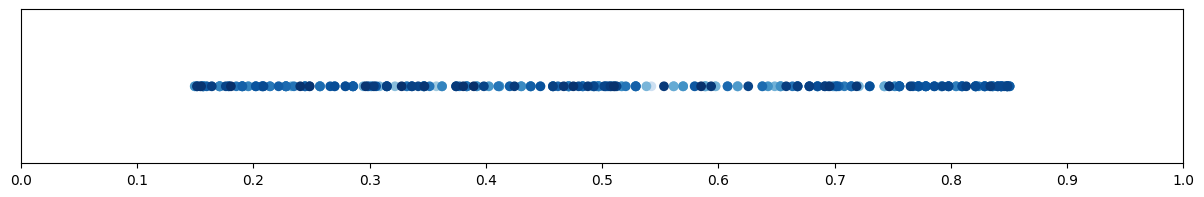

In [27]:
beliefs_x = np.array(belief_set)[:,1]

plt.figure(figsize=(15,2))
plt.scatter(beliefs_x, np.zeros(beliefs_x.shape[0]), c=range(beliefs_x.shape[0]), cmap='Blues')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

## Simulation

In [28]:
def simulate(alpha_set, alpha_actions, sim_length=1000):
    start_state = random.choice(STATES) # unknown to agent
    state = start_state
    print(f'Agent starts in state {start_state}')
    cum_rewards = []

    # Belief of the agent
    belief = [1/STATE_COUNT] * STATE_COUNT
    # alpha_set and alpha_actions are known
    
    reward_tot = 0

    for i in range(sim_length):
        # 1. Find best action to take under current belief
        best_value = -math.inf
        best_action = None
        for i, alpha in enumerate(alpha_set):
            val = sum((belief[s] * alpha[s]) for s in STATES)
            if val > best_value:
                best_value = val
                best_action = alpha_actions[i]

        # Apply action, unknown to agent
        state = transition(state, best_action)

        # 2. Observe
        o = observe(state)

        # 3. Update belief
        belief = belief_update(belief, a, o)

        # Receive reward
        reward = 1 if random.random() < REWARD_PROBS[state] else 0 
        reward_tot += reward
        
        cum_rewards.append(reward_tot)
        
        
    # Finalize
    print(f'Agent received a total reward of {reward_tot}, meaning an avaerage reward of {reward_tot/sim_length}')
    return cum_rewards

In [29]:
alpha_set, alpha_actions, belief_set, _ = pbvi_main([b_0], gamma_0, 8, 4, expand_ssea)

cum_rewards = simulate(alpha_set, alpha_actions, 10000)

  0%|          | 0/8 [00:00<?, ?it/s]

Agent starts in state 1
Agent received a total reward of 4454, meaning an avaerage reward of 0.4454


In [30]:
def plot_rewards(cum_rewards):
    N = 0
    if isinstance(cum_rewards, dict):
        N = len(cum_rewards[list(cum_rewards.keys())[0]])
    else:
        N = len(cum_rewards)
        
    x = [i for i in range(N)]

    y_best = [x_i*max(REWARD_PROBS) for x_i in x]

    plt.figure(figsize=(10,5))
    plt.plot(x,y_best, color='red', linestyle='--', label='Max rewards')

    if isinstance(cum_rewards, dict):
        for label, y_true in cum_rewards.items():
            plt.plot(x,y_true, label=label)
    else:
        plt.plot(x,cum_rewards, label='Cummulative rewards')

    plt.legend(loc='upper left')
    plt.show()

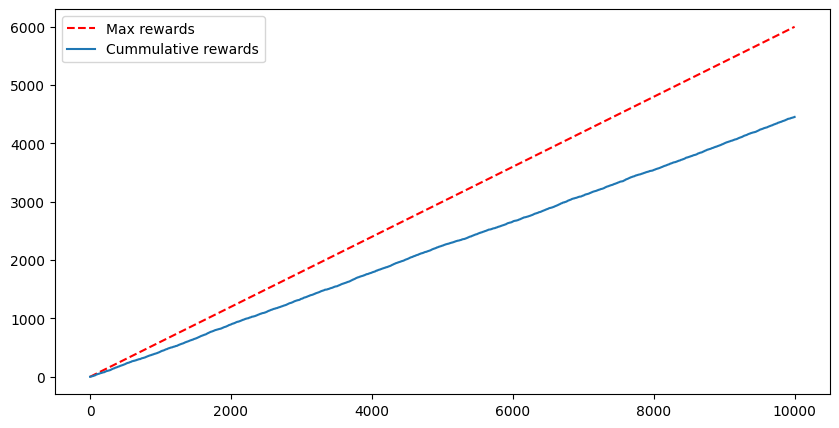

In [31]:
plot_rewards(cum_rewards)

## Tests

  0%|          | 0/8 [00:00<?, ?it/s]

Agent starts in state 1
Agent received a total reward of 447, meaning an avaerage reward of 0.447


  0%|          | 0/8 [00:00<?, ?it/s]

Agent starts in state 0
Agent received a total reward of 446, meaning an avaerage reward of 0.446


  0%|          | 0/8 [00:00<?, ?it/s]

Agent starts in state 0
Agent received a total reward of 439, meaning an avaerage reward of 0.439


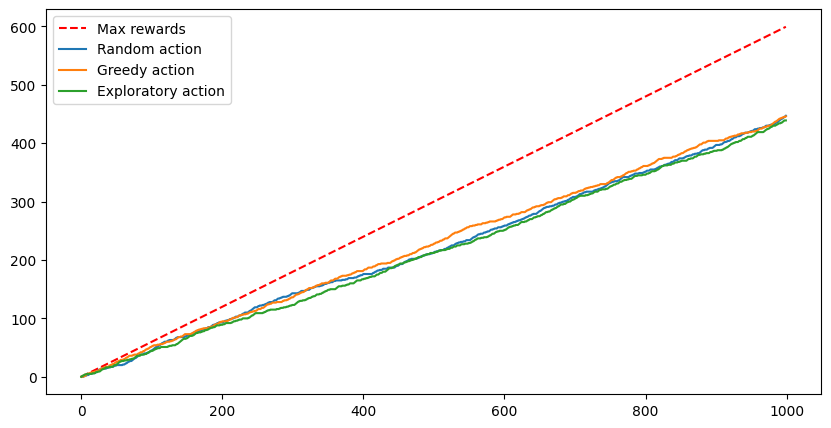

In [34]:
tests = {
    'Random action': expand_ssra,
    'Greedy action': expand_ssga,
    'Exploratory action': expand_ssea
}

results = {}

for name, expand_fnct in tests.items():
    alpha_set, alpha_actions, belief_set, _ = pbvi_main([b_0], gamma_0, 8, 4, expand_fnct)
    cum_rewards = simulate(alpha_set, alpha_actions, 1000)
    
    results[name] = cum_rewards

plot_rewards(results)

## Plotting value function

In [35]:
alpha_set, alpha_actions, belief_set, _ = pbvi_main([b_0], gamma_0, 8, 4, expand_ssea)

  0%|          | 0/8 [00:00<?, ?it/s]

In [36]:
len(alpha_set)

19

In [37]:
alpha_set[:10]

[array([4.17444796, 4.41444796]),
 array([4.41499711, 4.17375265]),
 array([4.17375265, 4.41499711]),
 array([4.17380262, 4.41496675]),
 array([4.16971191, 4.41650581]),
 array([4.41650581, 4.16971191]),
 array([4.41499173, 4.17376311]),
 array([4.41496675, 4.17380262]),
 array([4.16993785, 4.41643205]),
 array([4.42156021, 4.14910551])]

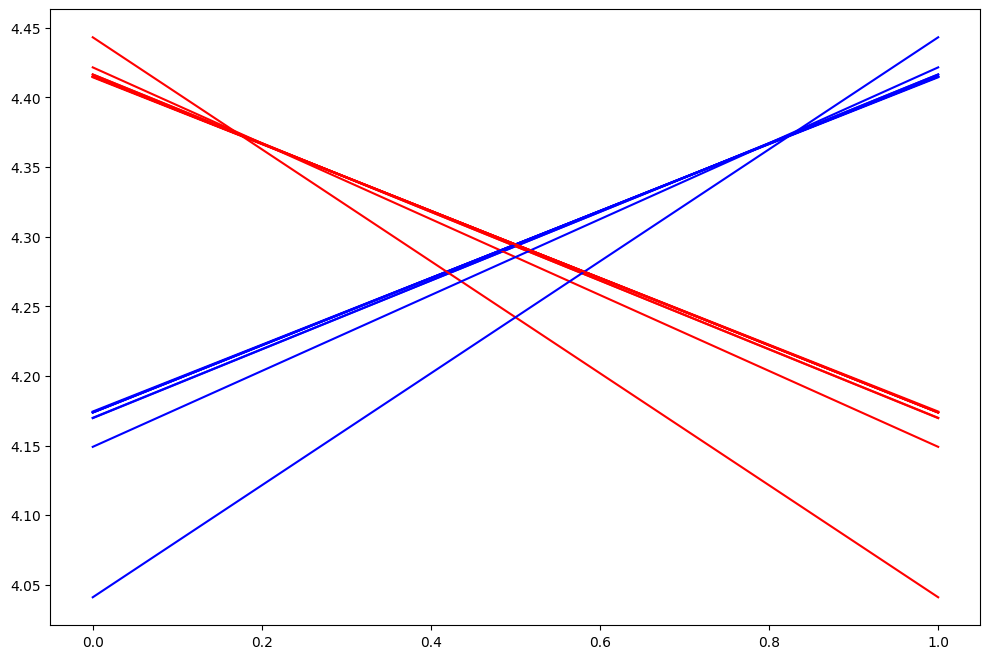

In [38]:
def plot_alpha_set(alpha_set, alpha_actions=None):
    x = np.linspace(0, 1, 1000)

    plt.figure(figsize=(12,8))

    for i, alpha in enumerate(alpha_set):
        m = alpha[1] - alpha[0]
        y = (m * x) + alpha[0]

        color = 'black'
        if alpha_actions is not None:
            color = 'blue' if alpha_actions[i] == STAY else 'red'

        plt.plot(x,y,c=color)

    plt.show()

plot_alpha_set(alpha_set, alpha_actions)

# MDP version of the problem

## Value iteration

In [39]:
# Initiallize V as a |S| x |A| matrix of the reward expected when being in state s and taking action a
# V = copy.deepcopy(reward_table)
# V = np.ones((STATE_COUNT, ACTION_COUNT)) * np.array(REWARD_PROBS).reshape((STATE_COUNT, 1)) # Starts with pure rewards
V = np.zeros((STATE_COUNT, ACTION_COUNT)) # Start at zero
V_opt = V[:,0]
gamma = 0.9
theta = 0.01 # Stops if average change in V is lower than this
N = 10000 # Infinite loop failsafe
converged = False

V_history = []

while (not converged) and (N > 0):
    N -= 1
    
    old_V = copy.deepcopy(V)
    old_V_opt = copy.deepcopy(V_opt)

    V = np.empty(old_V.shape)

    for s in STATES:
        for a_i, a in enumerate(ACTIONS):
            V[s,a_i] = reward_table[s,a] + (gamma * sum(transition_table[s, a_i, s_p] * old_V_opt[s_p] for s_p in STATES))

    V_opt = np.max(V, axis=1)
    V_history.append(V)

    avg_delta = np.average(np.abs(V_opt - old_V_opt))
    if avg_delta < theta:
        converged = True
        print(f'Converged with N remaining {N}')

Converged with N remaining 9961


In [40]:
V

array([[4.87459934, 5.11459934],
       [5.11459934, 4.87459934]])

In [41]:
V_alphas = []
V_alpha_actions = []
for a_i, a in enumerate(ACTIONS):
    V_alphas.append(V[:, a_i])
    V_alpha_actions.append(a)

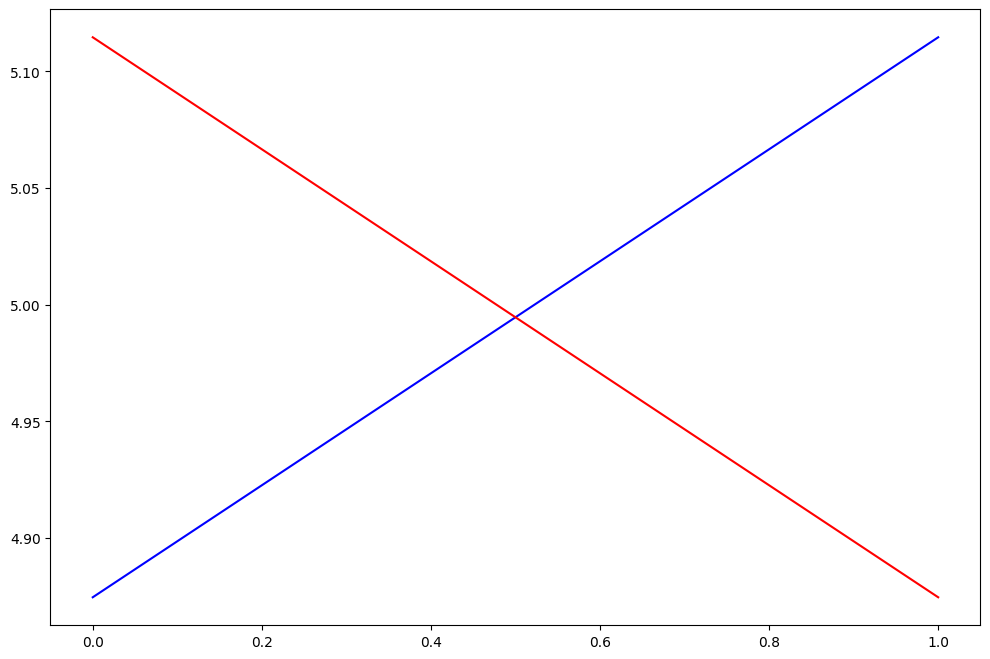

In [42]:
plot_alpha_set(V_alphas, V_alpha_actions)

# Investigation of intersection

In [43]:
def line_intersection(line1, line2):
    line1 = [[0,line1[0]],[1,line1[1]]]
    line2 = [[0,line2[0]],[1,line2[1]]]

    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [44]:
# Intersection for MDP Value function change
line_intersection(V_alphas[0], V_alphas[1])

(0.5, 4.994599343005049)

In [45]:
# For POMDP:

# Figuring out the 2 sets of vectors

sets = {'pos': [], 'neg':[]}

for alpha in alpha_set:
    if alpha[1] - alpha[0] > 0:
        sets['pos'].append(alpha)
    else:
        sets['neg'].append(alpha)

In [46]:
intersections = []
for neg_a in sets['neg']:
    for pos_a in sets['pos']:
        intersections.append(line_intersection(neg_a,pos_a))

intersections = np.array(intersections)

intersections[:5]

array([[0.49984814, 4.29441152],
       [0.5       , 4.29437488],
       [0.49997968, 4.29437978],
       [0.50259411, 4.29374907],
       [0.5024397 , 4.29378632]])

In [47]:
highest_intersection_index = np.argmax(intersections, axis=0)[1]

intersections[highest_intersection_index]

array([0.5       , 4.29444796])

Intersections match up

# Visualizing evolution over time

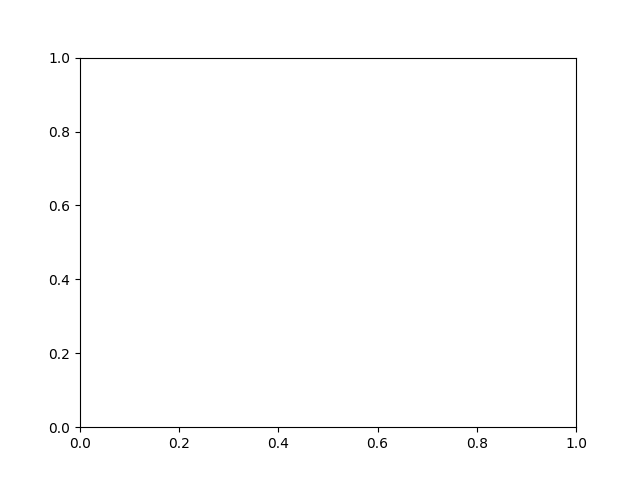

In [56]:
fig, ax = plt.subplots(1,1)

def animate(i):
    V_i = V_history[i]

    V_alphas = []
    V_alpha_actions = []
    for a_i, a in enumerate(ACTIONS):
        V_alphas.append(V_i[:, a_i])
        V_alpha_actions.append(a)

    x = np.linspace(0, 1, 1000)
    ax.clear()
    for i, alpha in enumerate(V_alphas):
        m = alpha[1] - alpha[0]
        y = (m * x) + alpha[0]

        color = 'black'
        if alpha_actions is not None:
            color = 'blue' if V_alpha_actions[i] == STAY else 'red'

        ax.plot(x,y,c=color)

ani = FuncAnimation(fig, animate, frames=len(V_history), interval=500, repeat=False)

plt.show()

In [57]:
alpha_set, alpha_actions, belief_set, pomdp_history = pbvi_main([b_0], gamma_0, 8, 8, expand_ssea)

  0%|          | 0/8 [00:00<?, ?it/s]

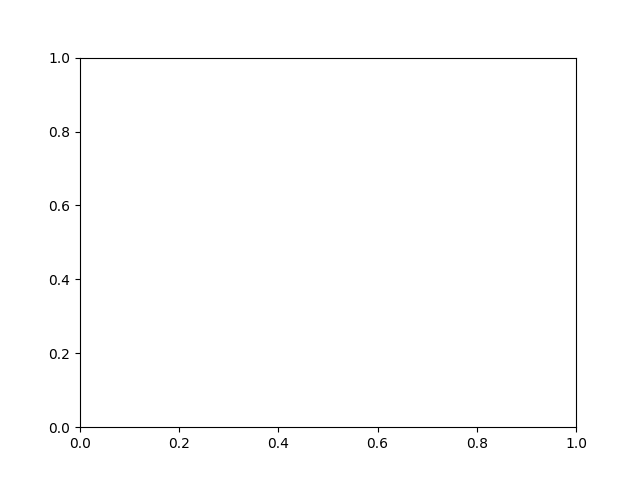

In [58]:
fig, ax = plt.subplots(1,1)

def animate(frame_i):
    x = np.linspace(0, 1, 1000)
    ax.clear()

    history_i = pomdp_history[frame_i]

    for i, alpha in enumerate(history_i['alphas']):
        m = alpha[1] - alpha[0]
        y = (m * x) + alpha[0]

        color = 'black'
        if history_i['alpha_actions'][i] is not None:
            color = 'blue' if history_i['alpha_actions'][i] == STAY else 'red'

        ax.plot(x,y,c=color)

ani = FuncAnimation(fig, animate, frames=len(pomdp_history), interval=500, repeat=False)

plt.show()

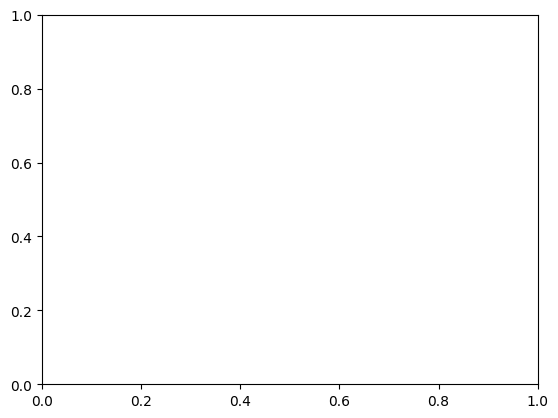

In [53]:
fig, ax = plt.subplots(1,1)

def animate(frame_i):
    x = np.linspace(0, 1, 1000)
    ax.clear()

    # MDP version
    if frame_i < len(V_history):
        V_i = V_history[frame_i]
    else:
        V_i = V_history[-1]
        
    V_alphas = []
    V_alpha_actions = []
    for a_i, a in enumerate(ACTIONS):
        V_alphas.append(V_i[:, a_i])
        V_alpha_actions.append(a)

    for i, alpha in enumerate(V_alphas):
        m = alpha[1] - alpha[0]
        y = (m * x) + alpha[0]

        color = 'black'
        if alpha_actions is not None:
            color = 'blue' if V_alpha_actions[i] == STAY else 'red'

        ax.plot(x,y,c=color, linestyle='--')

    # POMDP version
    if frame_i < len(pomdp_history):
        history_i = pomdp_history[frame_i]
    else:
        history_i = pomdp_history[-1]

    for i, alpha in enumerate(history_i['alphas']):
        m = alpha[1] - alpha[0]
        y = (m * x) + alpha[0]

        color = 'black'
        if alpha_actions is not None:
            color = 'blue' if history_i['alpha_actions'][i] == STAY else 'red'

        ax.plot(x,y,c=color)


ani = FuncAnimation(fig, animate, frames=max([len(V_history), len(pomdp_history)]), interval=500, repeat=False)

plt.show()

In [80]:
import matplotlib.animation as animation
# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=10)
ani.save('pomdp_mdp_val_comparisson.mp4', writer=writervideo)
plt.close()

# LP

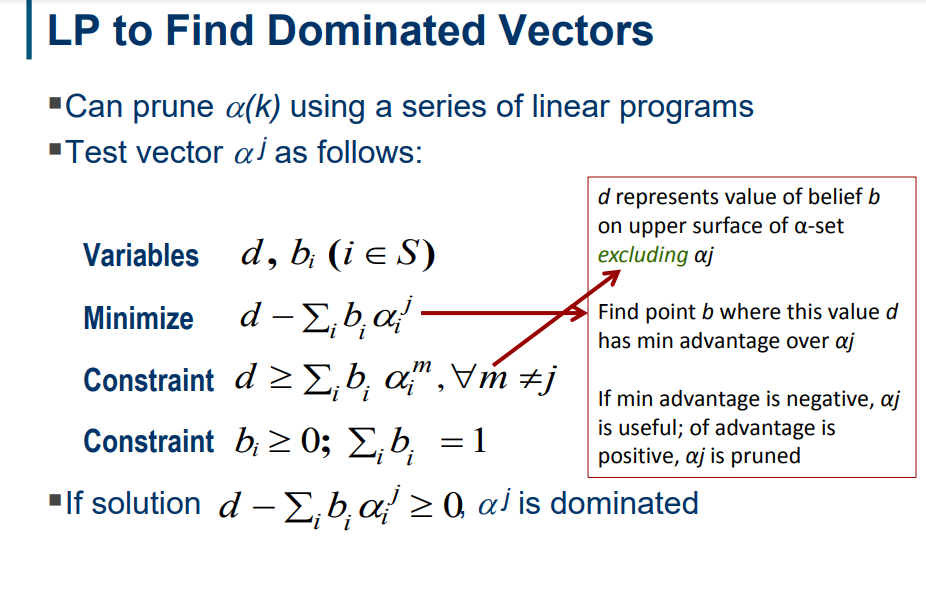

In [82]:
alpha_set

[array([4.30879194, 4.54879194]),
 array([4.54934109, 4.30809663]),
 array([4.30809663, 4.54934109]),
 array([4.30405588, 4.55084979]),
 array([4.30814659, 4.54931073]),
 array([4.54931073, 4.30814659]),
 array([4.28344948, 4.55590419]),
 array([4.55084979, 4.30405588]),
 array([4.55590419, 4.28344948]),
 array([4.5493357 , 4.30810709]),
 array([4.30810709, 4.5493357 ]),
 array([4.17544948, 4.57750419]),
 array([4.54879194, 4.30879194]),
 array([4.55077603, 4.30428183]),
 array([4.30428183, 4.55077603]),
 array([4.57750419, 4.17544948]),
 array([4.55084978, 4.30405593]),
 array([4.30405593, 4.55084978]),
 array([4.30814875, 4.54930915]),
 array([4.54930915, 4.30814875]),
 array([4.30879183, 4.54879204]),
 array([4.54879204, 4.30879183]),
 array([4.54934136, 4.30809595]),
 array([4.30809595, 4.54934136])]

In [61]:
alpha_vect = alpha_set[0]
other_alphas = alpha_set[1:]

In [63]:
c = np.concatenate([np.array([1]), -1*alpha_vect])


In [64]:
# Alpha vector contraints
other_count = len(other_alphas)
A = np.c_[np.ones(other_count), -1 * np.array(other_alphas)]
b_l = np.zeros(other_count)
b_u = np.full_like(b_l, np.inf)
alpha_constraints = LinearConstraint(A, b_l, b_u)

# Constraints that sum of beliefs is 1
belief_constraint = LinearConstraint(np.array([0] + ([1]*STATE_COUNT)), [1], [1])

# # All contraints
# constraints = LinearConstraint([alpha_constraints, belief_constraint])

In [65]:
res = milp(c=c, constraints=[alpha_constraints, belief_constraint])

In [66]:
res.x

array([4.42805561, 0.5       , 0.5       ])

In [68]:
res.x[0] - np.dot(res.x[1:], alpha_vect)

-8.165395470882686e-09

In [71]:
pruned_alphas = []

for i, alpha_vect in enumerate(alpha_set):
    other_alphas = alpha_set[:i] + alpha_set[(i+1):]

    # Objective function
    c = np.concatenate([np.array([1]), -1*alpha_vect])

    # Alpha vector contraints
    other_count = len(other_alphas)
    A = np.c_[np.ones(other_count), -1 * np.array(other_alphas)]
    b_l = np.zeros(other_count)
    b_u = np.full_like(b_l, np.inf)
    alpha_constraints = LinearConstraint(A, b_l, b_u)

    # Constraints that sum of beliefs is 1
    belief_constraint = LinearConstraint(np.array([0] + ([1]*STATE_COUNT)), [1], [1])

    # Solve problem
    res = milp(c=c, constraints=[alpha_constraints, belief_constraint])

    # Check if dominated
    is_dominated = (res.x[0] - np.dot(res.x[1:], alpha_vect)) >= 0
    if is_dominated:
        print(alpha_vect)
        print(' -> Dominated\n')

    else:
        pruned_alphas.append(alpha_vect)